https://www.kaggle.com/ozgeozkaya/sick-dataset

In [1]:
##import all required pakages
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jeane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [3]:
stemmer = SnowballStemmer('english')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
##need to install VC_redist.x64 before installing tensorflow

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [53]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, LSTM, Embedding, Dropout,Multiply,Concatenate, Activation,Lambda, Subtract,Flatten,TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.metrics
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.layers.core import Lambda
from sklearn.metrics import confusion_matrix, f1_score

In [79]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers.merge import concatenate

In [6]:
##import the data : available on : https://www.kaggle.com/ozgeozkaya/sick-dataset
data = pd.read_csv("D:/datasets_633450_1126605_SICK_train.txt", header = 0 ,sep="\t")

In [7]:
display(data)

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
...,...,...,...,...,...
4495,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,1.1,NEUTRAL
4496,9997,Someone is boiling okra in a pot,The man is not playing the drums,1.0,NEUTRAL
4497,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,1.0,NEUTRAL
4498,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,1.2,NEUTRAL


In [8]:
data.iloc[1,1]

'A group of children is playing in the house and there is no man standing in the background'

In [9]:
data.iloc[1,2]

'A group of kids is playing in a yard and an old man is standing in the background'

In [10]:
data.iloc[420,1]

'A man in a shirt dyed purple is walking away from a man in a black shirt, who is serious'

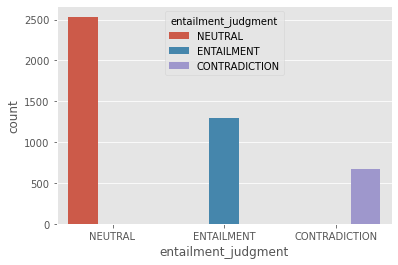

In [11]:
##barplot of the 'entailment_judgment' variable 

plt.style.use('ggplot')
sns.countplot(x='entailment_judgment', hue='entailment_judgment', data=data)
plt.savefig("stat_desc")

In [102]:
##categories size in the dataset 

print(data["entailment_judgment"].tolist().count('CONTRADICTION'))
print(data["entailment_judgment"].tolist().count('NEUTRAL'))
print(data["entailment_judgment"].tolist().count('ENTAILMENT'))

665
2536
1299


In [12]:
##recode the the 'entailment_judgment' variable 

conditions = [
        (data['entailment_judgment'] == 'CONTRADICTION'),
        (data['entailment_judgment'] == 'NEUTRAL'),
        (data['entailment_judgment'] == 'ENTAILMENT')]
choices = [0,1,2]

In [13]:
data['Y'] = np.select(conditions, choices)

Dans la suite de nous auront à preprocess le dataset.
La base de données est assez propores, de ce fait nous n'avons pas à enlever des caractères indésirables. Les phrases qui sont dans notre base de données ne sont pas trop longues, de plus certaines paires ne diffèrent rien que par la négation. Nous avons donc décider de ne pas enlever les stopwords. 

Nous aurons à remplacer les expresions contractées par leurs formes pleines
Enlever la ponctuation
Utiliser snow


In [18]:
## define a data preprocessing function

def clean_sentence(x,stem_words=True):                            
    tokens = word_tokenize(x)  ## tokenize
    tokens = [w.lower() for w in tokens] ## lowercase
    table = str.maketrans('', '', string.punctuation) ## remove ponctuation
    words = [w.translate(table) for w in tokens]
    if stem_words:                                    ##stem if you want
        words = [stemmer.stem(word) for word in words] 
    text = " ".join(words)
    return text

###define a sub-function that removes undesirable characters, and replace contracted forms
def general_clean_text(column_text,stem_words=True):    
    
    
    column_text = column_text.apply(lambda x: re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"what's", "what is ", x)) 
    
    
    column_text = column_text.apply(lambda x: re.sub(r"\'s", " ", x))
    
    column_text = column_text.apply(lambda x: re.sub(r"\'ve", " have ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"can't", "cannot ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"n't", " not ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"i'm", "i am ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"\'re", " are ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"\'d", " would ", x))
    
    
    column_text = column_text.apply(lambda x: re.sub(r"\'ll", " will ", x))
    
    column_text = column_text.apply(lambda x: clean_sentence(x,stem_words))
    
    return column_text


In [19]:
##apply the function

data['sentence_A']=general_clean_text(data['sentence_A'],stem_words=False)
data['sentence_B']=general_clean_text(data['sentence_B'],stem_words=False)

In [20]:
display(data)

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment,Y
0,1,a group of kids is playing in a yard and an ol...,a group of boys in a yard is playing and a man...,4.5,NEUTRAL,1
1,2,a group of children is playing in the house an...,a group of kids is playing in a yard and an ol...,3.2,NEUTRAL,1
2,3,the young boys are playing outdoors and the ma...,the kids are playing outdoors near a man with ...,4.7,ENTAILMENT,2
3,5,the kids are playing outdoors near a man with ...,a group of kids is playing in a yard and an ol...,3.4,NEUTRAL,1
4,9,the young boys are playing outdoors and the ma...,a group of kids is playing in a yard and an ol...,3.7,NEUTRAL,1
...,...,...,...,...,...,...
4495,9993,a door is being opened by a man,a bald man in a band is playing guitar in the ...,1.1,NEUTRAL,1
4496,9997,someone is boiling okra in a pot,the man is not playing the drums,1.0,NEUTRAL,1
4497,9998,the man is singing heartily and playing the gu...,a bicyclist is holding a bike over his head in...,1.0,NEUTRAL,1
4498,9999,a man in blue has a yellow ball in the mitt,a man is jumping rope outside,1.2,NEUTRAL,1


In [33]:
##split into train set and test set (validation set more precisely)

X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,1:3],data["Y"],test_size=0.3,random_state=random.seed(2))

In [34]:
print(len(X_train))
print(len(X_test))

3150
1350


In [109]:
##categories size in the test set

print(Y_test.tolist().count(0))
print(Y_test.tolist().count(1))
print(Y_test.tolist().count(2))

199
765
386


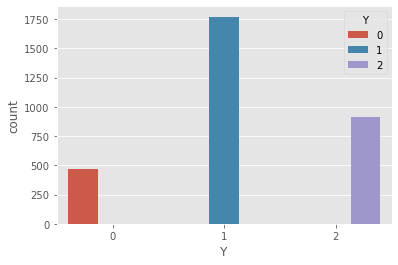

In [35]:
plt.style.use('ggplot')
sns.countplot(x=Y_train, hue=Y_train)

In [36]:
## tranform the target variable into one-hot-encoding variable

Y_train_onehot=LabelBinarizer().fit_transform(Y_train)
Y_test_onehot=LabelBinarizer().fit_transform(Y_test)

In [39]:
##combine the pair of sentences in a column named 'text'

data['text'] = data[['sentence_A','sentence_B']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1)

In [40]:
##tokenize the entire text in the coulmn text

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data['text'].values)

In [41]:
##assign an inter to each word found in the text column

tokenizer_obj.word_index 
len(tokenizer_obj.word_index) ##nomber of unique words

2168

In [42]:
##transform the the columns of data frame into lists
X_train_sentA=X_train['sentence_A'].tolist()
X_train_sentB=X_train['sentence_B'].tolist()
X_test_sentA=X_test['sentence_A'].tolist()
X_test_sentB=X_test['sentence_B'].tolist()


##vectorize  text corpus, by turning each text into a sequence of integers 
X_train_seqA = tokenizer_obj.texts_to_sequences(X_train_sentA)
X_train_seqB = tokenizer_obj.texts_to_sequences(X_train_sentB)
X_test_seqA = tokenizer_obj.texts_to_sequences(X_test_sentA)
X_test_seqB = tokenizer_obj.texts_to_sequences(X_test_sentB)

In [43]:
X_train_sentA[0:2]

['the black and white dog is running indoors',
 'a great dog is climbing a steep hill']

In [44]:
##each sentence is now a sequence of integer, this interger will be matched to the embeddings vector of the word
##in a dictionary
X_train_seqA[0:2]

[[3, 27, 6, 24, 11, 2, 28, 621], [1, 1003, 11, 2, 90, 1, 712, 137]]

In [45]:
#research among all the sentences the one which has the largest number of words , this will serve to determine 
## the dimension of the embedding layer

max_len = max(max([len(sent_vec) for sent_vec in X_train_seqA]),
              max([len(sent_vec) for sent_vec in X_train_seqB]),
              max([len(sent_vec) for sent_vec in X_test_seqA]),
              max([len(sent_vec) for sent_vec in X_test_seqB]))

max_len

32

In [46]:
##since all sentences don't have the same length, we pad them until with 0 so tht all the sentences will be 
##as long as the sentence which has the largest number of words

X_train_seqA = pad_sequences(X_train_seqA, maxlen=max_len, padding='post')
X_train_seqB = pad_sequences(X_train_seqB, maxlen=max_len, padding='post')
X_test_seqA = pad_sequences(X_test_seqA, maxlen=max_len, padding='post')
X_test_seqB = pad_sequences(X_test_seqB, maxlen=max_len, padding='post')

X_train_seqA[0:2]

array([[   3,   27,    6,   24,   11,    2,   28,  621,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1, 1003,   11,    2,   90,    1,  712,  137,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [47]:
X_train_seqA.shape

(3150, 32)

In [48]:
! pip install joblib

In [49]:
import joblib

In [50]:

#import a pretrained Glove for word embedding via https://www.kaggle.com/thanakomsn/glove6b300dtxt
#and create the dictionary that will contain each word and its vector

embeddings_index = {}
f = open('D:/5504_8240_compressed_glove_6B_300d_txt/glove_6B_300d.txt',encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [51]:
embeddings_index['patato']
len(embeddings_index['patato'])

300

In [52]:
not_present_list = [] ## create a empty list, it will keep the words which are in our vocabulary of the data and  not in the glove dictionnayr

vocab_size = len(tokenizer_obj.word_index) + 1  # adding 1 to fit Keras embedding (requirement)

print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no']))) ## initialize the embeddind matrix of shape (2169,300) to 0

for word, i in tokenizer_obj.word_index.items():    ## we browser whole of couples (word , index) that exist in the vocabulary of the data
    if word in embeddings_index.keys(): ## if the word which is in our vocabulary is in glove dictionnary, take its embedding vector
        embedding_vector = embeddings_index.get(word) 
    else:
        not_present_list.append(word)   ##else, add the word to the not_present_list, its embedding vector is None for the moment 
    if embedding_vector is not None:    ## set the embedding vector of word in the embedding matrix
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300) ## the embedding vector for unknown words, is 0


Loaded 400000 word vectors.


In [54]:
##create a function that computes the cosine cosine similarity 
###https://stackoverflow.com/questions/51003027/computing-cosine-similarity-between-two-
##tensors-in-keras/51003359#51003359

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)   ##compute normalize x to be a vector of norm 1
    y = K.l2_normalize(y, axis=-1)   ##compute normalize y to be a vector of norm 1
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [65]:
##Build the model

#### we introduce the the pair of sentences in the model, each sentence is an array of 
#### length X_train_seqA.shape[1] =32= max_len

input_1 = Input(shape=(X_train_seqA.shape[1],)) 
input_2 = Input(shape=(X_train_seqB.shape[1],))


##create the embedding layer 
common_embed = Embedding(name="embed_layer", input_dim = vocab_size, 
                       output_dim=len(embeddings_index['patato']),weights=[embedding_matrix], 
                       input_length=X_train_seqA.shape[1],trainable=False)

##get the embedded form of each word in the sentences
sent_1 = common_embed(input_1)
sent_2 = common_embed(input_2)

##create the bi-LSTM that will be run on the embedded sequences
common_bilstm = Bidirectional(LSTM(64,return_sequences=True, activation="tanh"))

vector_1 = common_bilstm(sent_1)
vector_1 = Flatten()(vector_1) ## flatten the vector


vector_2 = common_bilstm(sent_2)
vector_2 = Flatten()(vector_2)

## compute the square of each element of the vector vector_1-vector_2
x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

## compute the square of each element of the vector vector_1 and the vector_2 and substract
x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
##compute the cosine    
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
# concatenate    
conc = Concatenate(axis=-1)([x5,x4,x3])

## apply tanh function, a dropout and then a softmax function
x = Dense(100, activation="tanh", name='conc_layer')(conc)
x = Dropout(0.1)(x)
out = Dense(3, activation="softmax", name = 'out')(x)

model_lstm = Model([input_1, input_2], out)


In [66]:
model_lstm.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
embed_layer (Embedding)         (None, 32, 300)      650700      input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 32, 128)      186880      embed_layer[0][0]     

In [67]:
##compile the model by choosing the loss, the metrics and the otpimizer
model_lstm.compile(loss="categorical_crossentropy", metrics=['accuracy',keras.metrics.AUC()], optimizer=Adam(0.00001))

In [68]:
##fit the model
hist_lstm=model_lstm.fit([X_train_seqA,X_train_seqB], Y_train_onehot,validation_data=([X_test_seqA,X_test_seqB],Y_test_onehot),epochs=100,batch_size = 32)

Epoch 1/100
99/99 [==============================] - 15s 153ms/step - loss: 1.0656 - accuracy: 0.5286 - auc_2: 0.7085 - val_loss: 1.0336 - val_accuracy: 0.5667 - val_auc_2: 0.7565
Epoch 2/100
99/99 [==============================] - 10s 100ms/step - loss: 1.0002 - accuracy: 0.5635 - auc_2: 0.7687 - val_loss: 0.9765 - val_accuracy: 0.5667 - val_auc_2: 0.7639
Epoch 3/100
99/99 [==============================] - 9s 92ms/step - loss: 0.9471 - accuracy: 0.5625 - auc_2: 0.7750 - val_loss: 0.9336 - val_accuracy: 0.5667 - val_auc_2: 0.7664
Epoch 4/100
99/99 [==============================] - 8s 84ms/step - loss: 0.9082 - accuracy: 0.5625 - auc_2: 0.7784 - val_loss: 0.9061 - val_accuracy: 0.5667 - val_auc_2: 0.7687
Epoch 5/100
99/99 [==============================] - 9s 89ms/step - loss: 0.8824 - accuracy: 0.5629 - auc_2: 0.7818 - val_loss: 0.8904 - val_accuracy: 0.5667 - val_auc_2: 0.7704
Epoch 6/100
99/99 [==============================] - 9s 92ms/step - loss: 0.8662 - accuracy: 0.5629 - auc_

Epoch 47/100
99/99 [==============================] - 9s 88ms/step - loss: 0.4342 - accuracy: 0.8511 - auc_2: 0.9589 - val_loss: 0.6412 - val_accuracy: 0.7541 - val_auc_2: 0.8982
Epoch 48/100
99/99 [==============================] - 9s 88ms/step - loss: 0.4265 - accuracy: 0.8559 - auc_2: 0.9604 - val_loss: 0.6387 - val_accuracy: 0.7556 - val_auc_2: 0.8995
Epoch 49/100
99/99 [==============================] - 10s 100ms/step - loss: 0.4191 - accuracy: 0.8606 - auc_2: 0.9625 - val_loss: 0.6374 - val_accuracy: 0.7570 - val_auc_2: 0.9005
Epoch 50/100
99/99 [==============================] - 9s 93ms/step - loss: 0.4109 - accuracy: 0.8667 - auc_2: 0.9641 - val_loss: 0.6353 - val_accuracy: 0.7600 - val_auc_2: 0.9015
Epoch 51/100
99/99 [==============================] - 9s 89ms/step - loss: 0.4028 - accuracy: 0.8743 - auc_2: 0.9661 - val_loss: 0.6331 - val_accuracy: 0.7600 - val_auc_2: 0.9027
Epoch 52/100
99/99 [==============================] - 9s 91ms/step - loss: 0.3941 - accuracy: 0.8765 - 

Epoch 93/100
99/99 [==============================] - 10s 96ms/step - loss: 0.1823 - accuracy: 0.9552 - auc_2: 0.9945 - val_loss: 0.6633 - val_accuracy: 0.7815 - val_auc_2: 0.9142
Epoch 94/100
99/99 [==============================] - 9s 95ms/step - loss: 0.1780 - accuracy: 0.9575 - auc_2: 0.9948 - val_loss: 0.6668 - val_accuracy: 0.7770 - val_auc_2: 0.9128
Epoch 95/100
99/99 [==============================] - 9s 90ms/step - loss: 0.1749 - accuracy: 0.9578 - auc_2: 0.9949 - val_loss: 0.6694 - val_accuracy: 0.7800 - val_auc_2: 0.9136
Epoch 96/100
99/99 [==============================] - 9s 87ms/step - loss: 0.1719 - accuracy: 0.9581 - auc_2: 0.9952 - val_loss: 0.6731 - val_accuracy: 0.7800 - val_auc_2: 0.9131
Epoch 97/100
99/99 [==============================] - 11s 106ms/step - loss: 0.1680 - accuracy: 0.9578 - auc_2: 0.9956 - val_loss: 0.6755 - val_accuracy: 0.7793 - val_auc_2: 0.9132
Epoch 98/100
99/99 [==============================] - 10s 100ms/step - loss: 0.1649 - accuracy: 0.9613

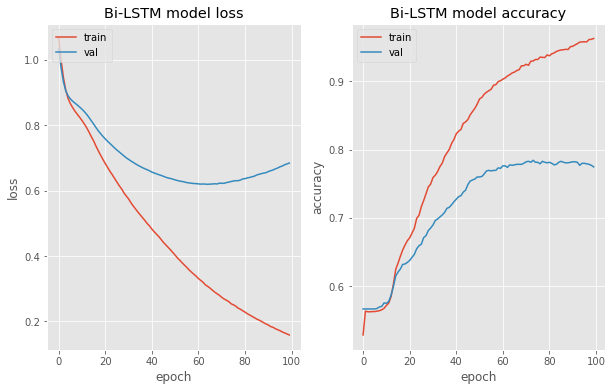

In [69]:
##plot the loss function and the accuracy
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.plot(hist_lstm.history['loss'])
plt.plot(hist_lstm.history['val_loss'])
plt.title('Bi-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hist_lstm.history['accuracy'])
plt.plot(hist_lstm.history['val_accuracy'])
plt.title('Bi-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_acc_lstm.PNG")
plt.show()

In [70]:
##prediction on the test set
Y_pred_lstm = np.argmax(model_lstm.predict([X_test_seqA,X_test_seqB]), axis=1)
Y_test_array = np.asarray(Y_test)

In [72]:
##compute the confusion matrix and the F1-score
cm_lstm = confusion_matrix(Y_test_array,Y_pred_lstm,labels=[0,1,2])
print(cm_lstm)
print("LSTM F1-Score: %0.3f " % (f1_score(Y_test_array,Y_pred_lstm, average="macro")))

[[153  35  11]
 [ 18 645 102]
 [  9 129 248]]
LSTM F1-Score: 0.764 


In [112]:
Y_pred_lstm_pd=pd.DataFrame(data=Y_pred_lstm)

In [113]:
error_analys = pd.concat([X_test,Y_test,Y_pred_lstm_pd],axis=1)

In [ ]:
error_analys[(error_analys['Y_pred_lstm_pd'] == 1)&(error_analys['Y_pred_lstm_pd'] == 2)].head()

In [73]:
## Here we define a fonction to plot the confusion matrix 

##https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,color='Greens'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['CONTRADICTION','NEUTRAL','ENTAILMENT']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap(color)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

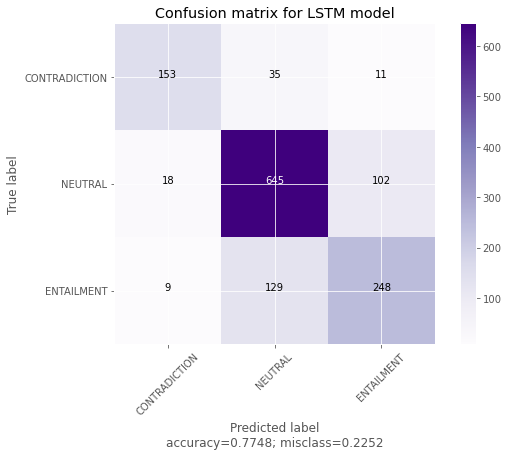

<Figure size 432x288 with 0 Axes>

In [105]:
####plot the confusion matrix with the defined function
plot_confusion_matrix(cm_lstm,['CONTRADICTION','NEUTRAL','ENTAILMENT']
                          ,
                          title= 'Confusion matrix for LSTM model',
                          cmap=None,
                          normalize=False,color='Purples')
plt.savefig("matrix_conf_lstm.PNG")

In [95]:
##Build the model CNN

####we introduce the the pair of sentences in the model, each sentence is an array of length X_train_seqA.shape[1] =32

input_1 = Input(shape=(X_train_seqA.shape[1],)) 
input_2 = Input(shape=(X_train_seqB.shape[1],))


##create the embedding layer 
common_embed = Embedding(name="embed_layer", input_dim = vocab_size, 
                       output_dim=len(embeddings_index['patato']),weights=[embedding_matrix], 
                       input_length=X_train_seqA.shape[1],trainable=False)

##get the embedded form of each word in the sentences
sent_1 = common_embed(input_1)
sent_2 = common_embed(input_2)

##build 1D convolutional layer with different filter sizes, each of them is followed by max pooling layer
filter_sizes = [3,4,5]
convs1 = []

for filter_size in filter_sizes:
    l_conv1 = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(sent_1)
    l_pool1 = MaxPooling1D(pool_size=3)(l_conv1)
    convs1.append(l_pool1)

##merge the different output    
l_merge1 = concatenate([convs1[0],convs1[1],convs1[2]],axis=1)

##apply dropout, flatten and apply a tanh function
vector_1 = Dropout(0.1)(l_merge1)
vector_1 = Flatten()(vector_1)
vector_1 = Dense(64, activation='tanh')(vector_1) 

convs2 = []
for filter_size in filter_sizes:
    l_conv2 = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(sent_2)
    l_pool2 = MaxPooling1D(pool_size=3)(l_conv2)
    convs2.append(l_pool2)

##same as before

l_merge2 = concatenate([convs2[0],convs2[1],convs2[2]],axis=1)

vector_2 = Dropout(0.1)(l_merge2)
vector_2 = Flatten()(vector_2)
vector_2 = Dense(64, activation='tanh')(vector_2) 

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4,x3])

## apply tanh function, a dropout and then a softmax function

x = Dense(100, activation="tanh", name='conc_layer')(conc)
x = Dropout(0.5)(x)
out = Dense(3, activation="softmax", name = 'out')(x)

model_cnn = Model([input_1, input_2], out)

model_cnn.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000001C53831E6A0>>

In [96]:
model_cnn.compile(loss="categorical_crossentropy", metrics=['accuracy',keras.metrics.AUC()], optimizer=Adam(0.00001))

In [97]:
hist_cnn = model_cnn.fit([X_train_seqA,X_train_seqB], Y_train_onehot,validation_data=([X_test_seqA,X_test_seqB],Y_test_onehot),epochs=100,batch_size = 32)

Epoch 1/100
99/99 [==============================] - 8s 84ms/step - loss: 1.0948 - accuracy: 0.4187 - auc_7: 0.6020 - val_loss: 0.9739 - val_accuracy: 0.5556 - val_auc_7: 0.7166
Epoch 2/100
99/99 [==============================] - 7s 68ms/step - loss: 1.0246 - accuracy: 0.5067 - auc_7: 0.6840 - val_loss: 0.9632 - val_accuracy: 0.5644 - val_auc_7: 0.7233
Epoch 3/100
99/99 [==============================] - 6s 64ms/step - loss: 1.0003 - accuracy: 0.5295 - auc_7: 0.7004 - val_loss: 0.9568 - val_accuracy: 0.5667 - val_auc_7: 0.7271
Epoch 4/100
99/99 [==============================] - 6s 63ms/step - loss: 0.9848 - accuracy: 0.5394 - auc_7: 0.7089 - val_loss: 0.9521 - val_accuracy: 0.5644 - val_auc_7: 0.7303
Epoch 5/100
99/99 [==============================] - 6s 62ms/step - loss: 0.9692 - accuracy: 0.5489 - auc_7: 0.7199 - val_loss: 0.9479 - val_accuracy: 0.5674 - val_auc_7: 0.7338
Epoch 6/100
99/99 [==============================] - 6s 61ms/step - loss: 0.9510 - accuracy: 0.5381 - auc_7: 0

Epoch 92/100
99/99 [==============================] - 7s 72ms/step - loss: 0.2819 - accuracy: 0.9127 - auc_7: 0.9855 - val_loss: 0.9730 - val_accuracy: 0.5904 - val_auc_7: 0.7853
Epoch 93/100
99/99 [==============================] - 7s 73ms/step - loss: 0.2751 - accuracy: 0.9143 - auc_7: 0.9866 - val_loss: 0.9757 - val_accuracy: 0.5889 - val_auc_7: 0.7842
Epoch 94/100
99/99 [==============================] - 7s 71ms/step - loss: 0.2739 - accuracy: 0.9175 - auc_7: 0.9869 - val_loss: 0.9836 - val_accuracy: 0.5881 - val_auc_7: 0.7857
Epoch 95/100
99/99 [==============================] - 8s 77ms/step - loss: 0.2617 - accuracy: 0.9210 - auc_7: 0.9884 - val_loss: 0.9967 - val_accuracy: 0.5926 - val_auc_7: 0.7869
Epoch 96/100
99/99 [==============================] - 8s 77ms/step - loss: 0.2644 - accuracy: 0.9175 - auc_7: 0.9869 - val_loss: 0.9920 - val_accuracy: 0.5904 - val_auc_7: 0.7840
Epoch 97/100
99/99 [==============================] - 7s 69ms/step - loss: 0.2590 - accuracy: 0.9194 - au

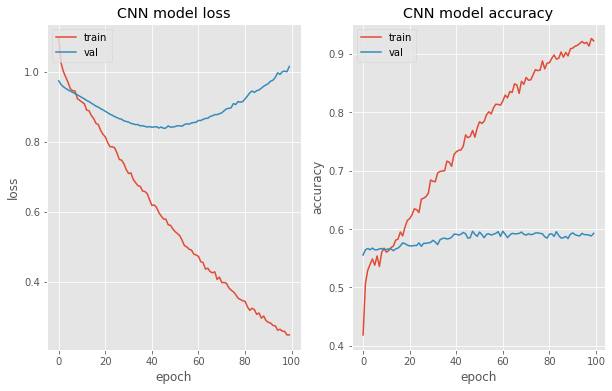

In [117]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_acc_cnn.PNG")
plt.show()

In [99]:
##prediction with the CNN model
Y_pred_cnn = np.argmax(model_cnn.predict([X_test_seqA,X_test_seqB]), axis=1)

In [103]:
##confusion matrix and F1-score
cm_cnn = confusion_matrix(Y_test_array,Y_pred_cnn,labels=[0,1,2])
print(cm_cnn)
print("CNN F1-Score: %0.3f " % (f1_score(Y_test_array,Y_pred_cnn, average="macro")))

[[ 96  87  16]
 [ 57 560 148]
 [  7 235 144]]
CNN F1-Score: 0.543 


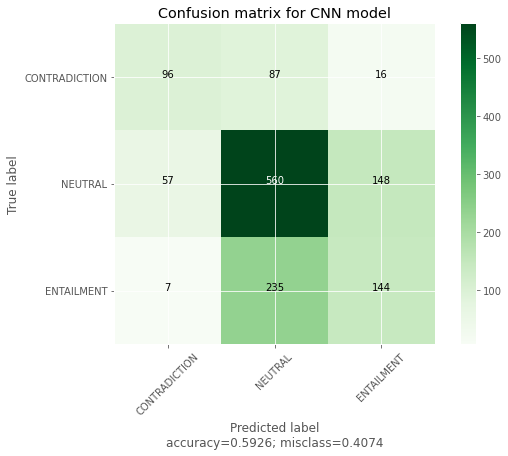

<Figure size 432x288 with 0 Axes>

In [107]:
##plot the confusion matrix with the defined function
plot_confusion_matrix(cm_cnn,['CONTRADICTION','NEUTRAL','ENTAILMENT']
                          ,
                          title='Confusion matrix for CNN model',
                          cmap=None,
                          normalize=False,color='Greens')
plt.savefig("matrix_conf_cnn.PNG")